# demo simple-track on JASMIN

* Developed by Calum Scullion (calum.scullion@metoffice.gov.uk) and Mark Muetzelfeldt (mark.muetzelfeldt@reading.ac.uk)
* Used a modified version of the simple-track code to produce tracks. Original code found here: https://github.com/thmstein/simple-track
* Can only be run on JASMIN

In [1]:
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

# Reduce figure size.
mpl.rcParams['figure.dpi'] = 72

# Need module `classes` to be available in namespace before we can unpickle tracks.
import classes  # Technically you don't need to import but do it explicitly so people can see where the classes are defined.

In [2]:
basepath = Path('/work/scratch-nopw2/cscullio/MCS_tracking_fd/DYMECS/')
dirpath_tpl = '{dataset}/Tb/40000km2/tracks/241K/20200201-20210228/fixed/geom_cen/60min/sm_5pixels/halo_0pixels/removed_false_mergers/on_GPM_True/'
datasets = ['5km-RAL3', 'CTC_km4p4_RAL3P3', '10km-GAL9', '10km-CoMA9 and 5km-RAL3']

dataset = '5km-RAL3'
assert dataset in datasets, f'{dataset} not recognized'
dirpath = basepath / dirpath_tpl.format(dataset=dataset)

In [3]:
pkl_paths = sorted(dirpath.glob('tracks_*.p'))
print([p.name for p in pkl_paths])
pkl_path = pkl_paths[0]

['tracks_202002.p', 'tracks_202003.p', 'tracks_202004.p', 'tracks_202005.p', 'tracks_202006.p', 'tracks_202007.p', 'tracks_202008.p', 'tracks_202009.p', 'tracks_202010.p', 'tracks_202011.p', 'tracks_202012.p', 'tracks_202101.p', 'tracks_202102.p']


In [4]:
# Loads tracks from the UM 5km RAL3 stored as a pickle in JASMIN scratch.
with pkl_path.open('rb') as f:
    tracks = pickle.load(f)

In [5]:
# Required to estimate storm size
def haversine(src, dest):
    # src/dest = (lat, lon)
    # Returns distance in km
    src = np.radians(src)
    dest = np.radians(dest)
    a = (np.sin(0.5 * (src[0]-dest[0]))**2 + np.cos(src[0]) * np.cos(dest[0]) * np.sin(0.5 * (src[1]-dest[1]))**2)
    angsep_in_rad = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    return angsep_in_rad / 1000.0 * 6371229.0

In [6]:
# Filter tracks
min_track_length = 4 # hours
cct_threshold = 225 # Minimum Tb must be < 225K during the MCS lifetime to account for overshooting tops
object_rain_above = 10 # mm/hour for 4 hours
hourly_precip_volume_threshold = 20000 # 20000 km**2 mm/h
grid_length = 10 # km, GPM grid
grid_length_deg = 0.1 # deg, GPM grid

nTracks = len(tracks)
print(f"{nTracks} tracks exist")

tracks = [track for track in tracks if track.get_lifetime() > min_track_length]
print(f"{nTracks - len(tracks)} tracks less than 4h, {len(tracks)} remain")
nTracks = len(tracks)

tracks = [track for track in tracks if all([track.get_storms()[i].minTb < cct_threshold for i in np.arange(track.get_lifetime())])]
print(f"{nTracks - len(tracks)} tracks do not have a min Tb < {cct_threshold}, {len(tracks)} remain")
nTracks = len(tracks)
 
tracks = [track for track in tracks if any(all(track.get_storms()[i+j].maxpr > object_rain_above for j in range(4)) for i in range(track.get_lifetime() - 3))]
print(f"{nTracks - len(tracks)} tracks do not have a max precip rate > {object_rain_above} for 4 consecutive hours, {len(tracks)} remain")
nTracks = len(tracks)

# .area is number of grid boxes, not km**2, so use haversine to estimate grid box areas to km**2 assuming latitude of storm centre is a good estimate of longitude length
tracks = [track for track in tracks if any([(track.get_storms()[i].meanpr * (track.get_storms()[i].area * grid_length * haversine([track.get_storms()[i].centroidlat, 0], [track.get_storms()[i].centroidlat, grid_length_deg])))
             > hourly_precip_volume_threshold for i in np.arange(track.get_lifetime())])]
print(f"{nTracks - len(tracks)} tracks do not have a max hourly_precip_volume_threshold > {hourly_precip_volume_threshold}, {len(tracks)} remain")
nTracks = len(tracks)


9918 tracks exist
6475 tracks less than 4h, 3443 remain
747 tracks do not have a min Tb < 225, 2696 remain
419 tracks do not have a max precip rate > 10 for 4 consecutive hours, 2277 remain
12 tracks do not have a max hourly_precip_volume_threshold > 20000, 2265 remain


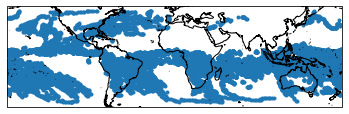

In [7]:
f = plt.figure()
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
lons = [storm.centroidlon for track in tracks for storm in track.get_storms()]
lats = [storm.centroidlat for track in tracks for storm in track.get_storms()]

plt.scatter(lons, lats, marker=".")
ax.coastlines("50m")